# Data Preprocessing

After the exploration of the dataset, we will now preprocess the data as stated in the previous notebook. The preprocessing steps include:
1. **Removing unnecessary columns**: Dropping columns that are not needed for the analysis.
2. **Correcting the data types**: Ensuring that each column has the correct data type.
3. **Encoding categorical variables**: Converting categorical variables into numerical format.
4. **Handling missing values**: Filling or dropping missing values as appropriate.
5. **Scaling numerical features**: Normalizing or standardizing numerical features to ensure they are on a similar scale.


We will load the data first

In [16]:
import pandas as pd

from stroke_prediction.config import RAW_DATA_DIR

data = pd.read_csv(RAW_DATA_DIR / "healthcare-dataset-stroke-data.csv")

data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We will split the data into training and testing sets, and then apply the preprocessing steps to both sets. This ensures that the model is trained and tested on data that has been processed in the same way. However, in production, we will extract this preprocessing into pipeline which can apply to the new data. So that test set is not leaked into the training set.

In [17]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=["stroke"])
y = data["stroke"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

First we will remove the `id` column as it is not useful for our analysis. We will also drop the `gender` and `Residence_type` as its correlation with the target variable is very close to zero.

In [3]:
X_train = X_train.drop(columns=["id", "gender", "Residence_type"])

Next we will convert the `ever_married` column to a binary format, where 'Yes' is 1 and 'No' is 0.

In [4]:
X_train["ever_married"] = X_train["ever_married"].map({"Yes": 1, "No": 0})

Also for the `age` column, we will convert it to an integer type.

In [5]:
X_train["age"] = X_train["age"].astype(int)

Next, we will encode the categorical variables.

In [6]:
X_train = pd.get_dummies(X_train, columns=["work_type", "smoking_status"], drop_first=True)

Next, we will handle the missing values. For the `bmi` column, we will impute the missing values with the mean of the column.
For the `smoking_status` column, we will try imputing the `Unknown` first, and compare it with whether left it as it is.

In [7]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
imputer.set_output(transform="pandas")
X_train = imputer.fit_transform(X_train)

Next, we will handle the numerical features.

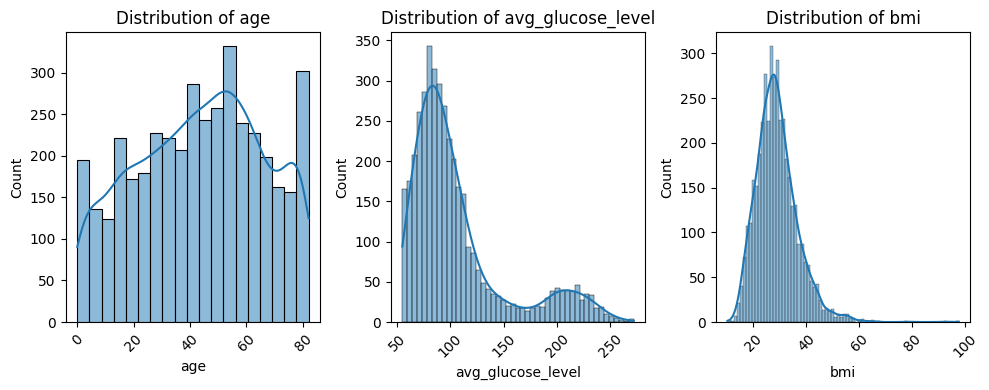

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

numberic_features = ['age', 'avg_glucose_level', 'bmi']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i, col in enumerate(numberic_features):
    ax = axes[i]
    sns.histplot(X_train[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [11]:
X_train.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
802,79.0,0.0,0.0,1.0,112.64,28.5,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3927,62.0,0.0,0.0,1.0,88.32,36.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2337,21.0,0.0,0.0,0.0,59.52,33.7,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3910,31.0,0.0,0.0,1.0,65.70,30.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1886,31.0,0.0,0.0,0.0,59.63,19.9,0.0,1.0,0.0,0.0,0.0,1.0,0.0


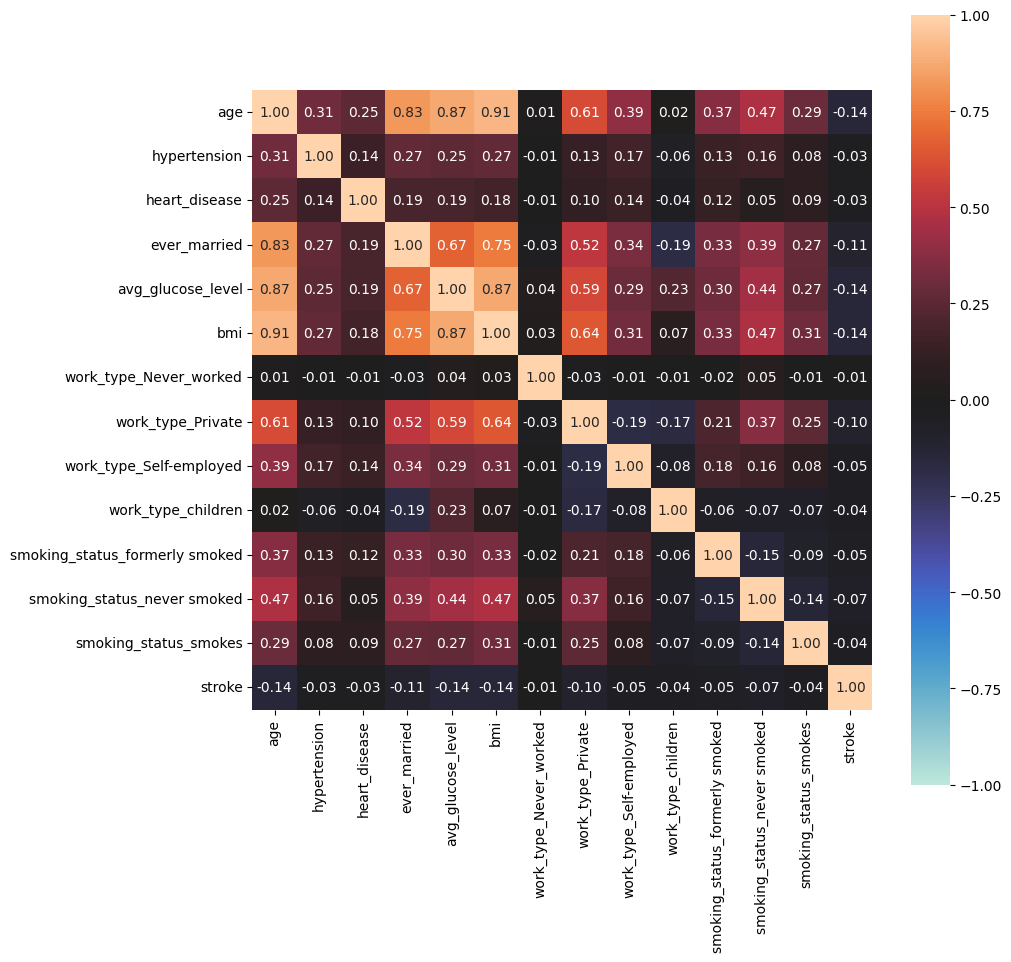

In [10]:
from dython.nominal import associations

associations(pd.concat([X_train.astype("float"), y_train.astype("float")]), figsize=(10, 10), num_num_assoc="spearman");

In [14]:
from stroke_prediction.config import PROCESSED_DATA_DIR

pd.concat([X_train, y_train], axis=1).to_csv(PROCESSED_DATA_DIR / "train-stroke-data.csv", index=False)

# Convert to pipeline

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

drop_cols = ["id", "gender", "Residence_type"]


column_transformer = ColumnTransformer(
    transformers=[
        ("drop", "drop", drop_cols),
        ("one_hot", OneHotEncoder(sparse_output=False, drop="first"), ["ever_married", "work_type", "smoking_status"]),
    ],
    remainder="passthrough",
    force_int_remainder_cols=False
)

pipeline = Pipeline(steps=[
    ("column_transformer", column_transformer),
    ("imputer", KNNImputer(n_neighbors=5))
])

In [41]:
pipeline.fit(X_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['id', 'gender',
                                                   'Residence_type']),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['ever_married', 'work_type',
                                                   'smoking_status'])])),
                ('imputer', KNNImputer())])

In [45]:
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [46]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=pipeline.get_feature_names_out())
X_test_transformed = pd.DataFrame(X_test_transformed, columns=pipeline.get_feature_names_out())

In [50]:
from stroke_prediction.config import PROCESSED_DATA_DIR

pd.concat([X_train_transformed, y_train], axis=1).to_csv(PROCESSED_DATA_DIR / "train-stroke-data.csv", index=False)
pd.concat([X_test_transformed, y_test], axis=1).to_csv(PROCESSED_DATA_DIR / "test-stroke-data.csv", index=False)